# Chi-Square Test for Age-[O/Fe] of Multi-Zone Outputs

In [23]:
import sys
import os
sys.path.append(os.path.abspath('../src/scripts'))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multizone_stars import MultizoneStars
from apogee_tools import import_apogee, apogee_region, apogee_mdf
from age_ofe import plot_astroNN_medians, plot_vice_medians
from score_multizone_outputs import score_age_ofe
import paths
import _globals
from utils import get_bin_centers, kl_divergence, group_by_bins

In [24]:
apogee_data = import_apogee()
mzs1 = MultizoneStars.from_output('gaussian/insideout/plateau_width10/diskmodel')
# mzs2 = MultizoneStars.from_output('gaussian/insideout/prompt/diskmodel')
# mzs3 = MultizoneStars.from_output('gaussian/earlyburst/plateau_width10/diskmodel')

In [25]:
def redchisq(obs, model, sig):
    chisq = ((obs - model)**2 / sig**2).sum()
    dof = obs.shape[0] - 1
    return chisq / dof

In [49]:
def simple_hist(x, **kwargs):
    return np.histogram(x, **kwargs)[0]

def age_ofe_kld(vice_stars, apogee_data, ofe_lim=(-0.15, 0.6), ofe_bin_width=0.05):
    ofe_bins = np.arange(ofe_lim[0], ofe_lim[1]+ofe_bin_width, ofe_bin_width)
    log_age_bins = np.arange(-1, np.log10(15), 0.1)
    # bin APOGEE ages by [O/Fe]
    apogee_grouped = group_by_bins(apogee_data, 'O_FE', ofe_bins)['LOG_LATENT_AGE']
    # APOGEE age DF for each bin in [O/Fe]
    apogee_adfs = apogee_grouped.apply(simple_hist, bins=log_age_bins, density=True)
    # count all APOGEE stars in each bin
    apogee_counts = apogee_grouped.count()
    # VICE age DF for each bin in [O/Fe]
    vice_stars['log_age'] = np.log10(vice_stars['age'])
    vice_grouped = group_by_bins(vice_stars, '[o/fe]', bins=ofe_bins)['log_age']
    vice_adfs = vice_grouped.apply(simple_hist, bins=log_age_bins, density=True)
    # count all VICE stars in each bin
    vice_counts = vice_grouped.count()
    # KL divergence test between APOGEE and VICE age DFs in each [O/Fe] bin
    age_df = pd.DataFrame({'APOGEE': apogee_adfs, 'VICE': vice_adfs, 'APOGEE_COUNTS': apogee_counts, 'VICE_COUNTS': vice_counts})
    # limit to [O/Fe] bins where data and model both have stars
    age_df = age_df[(apogee_counts > 10) & (vice_counts > 10)]
    if age_df.shape[0] > 0:
        age_df['KL_DIV'] = age_df.apply(lambda x: kl_divergence(x['APOGEE'], x['VICE'], 0.1), axis=1)
        # Average KL divergence over all [O/Fe] bins, weighted by APOGEE counts
        return np.average(age_df['KL_DIV'], weights=age_df['APOGEE_COUNTS'])
    else:
        return np.nan

/home/lodubay/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/lodubay/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/lodubay/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/lodubay/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/lodubay/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/lodubay/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edge

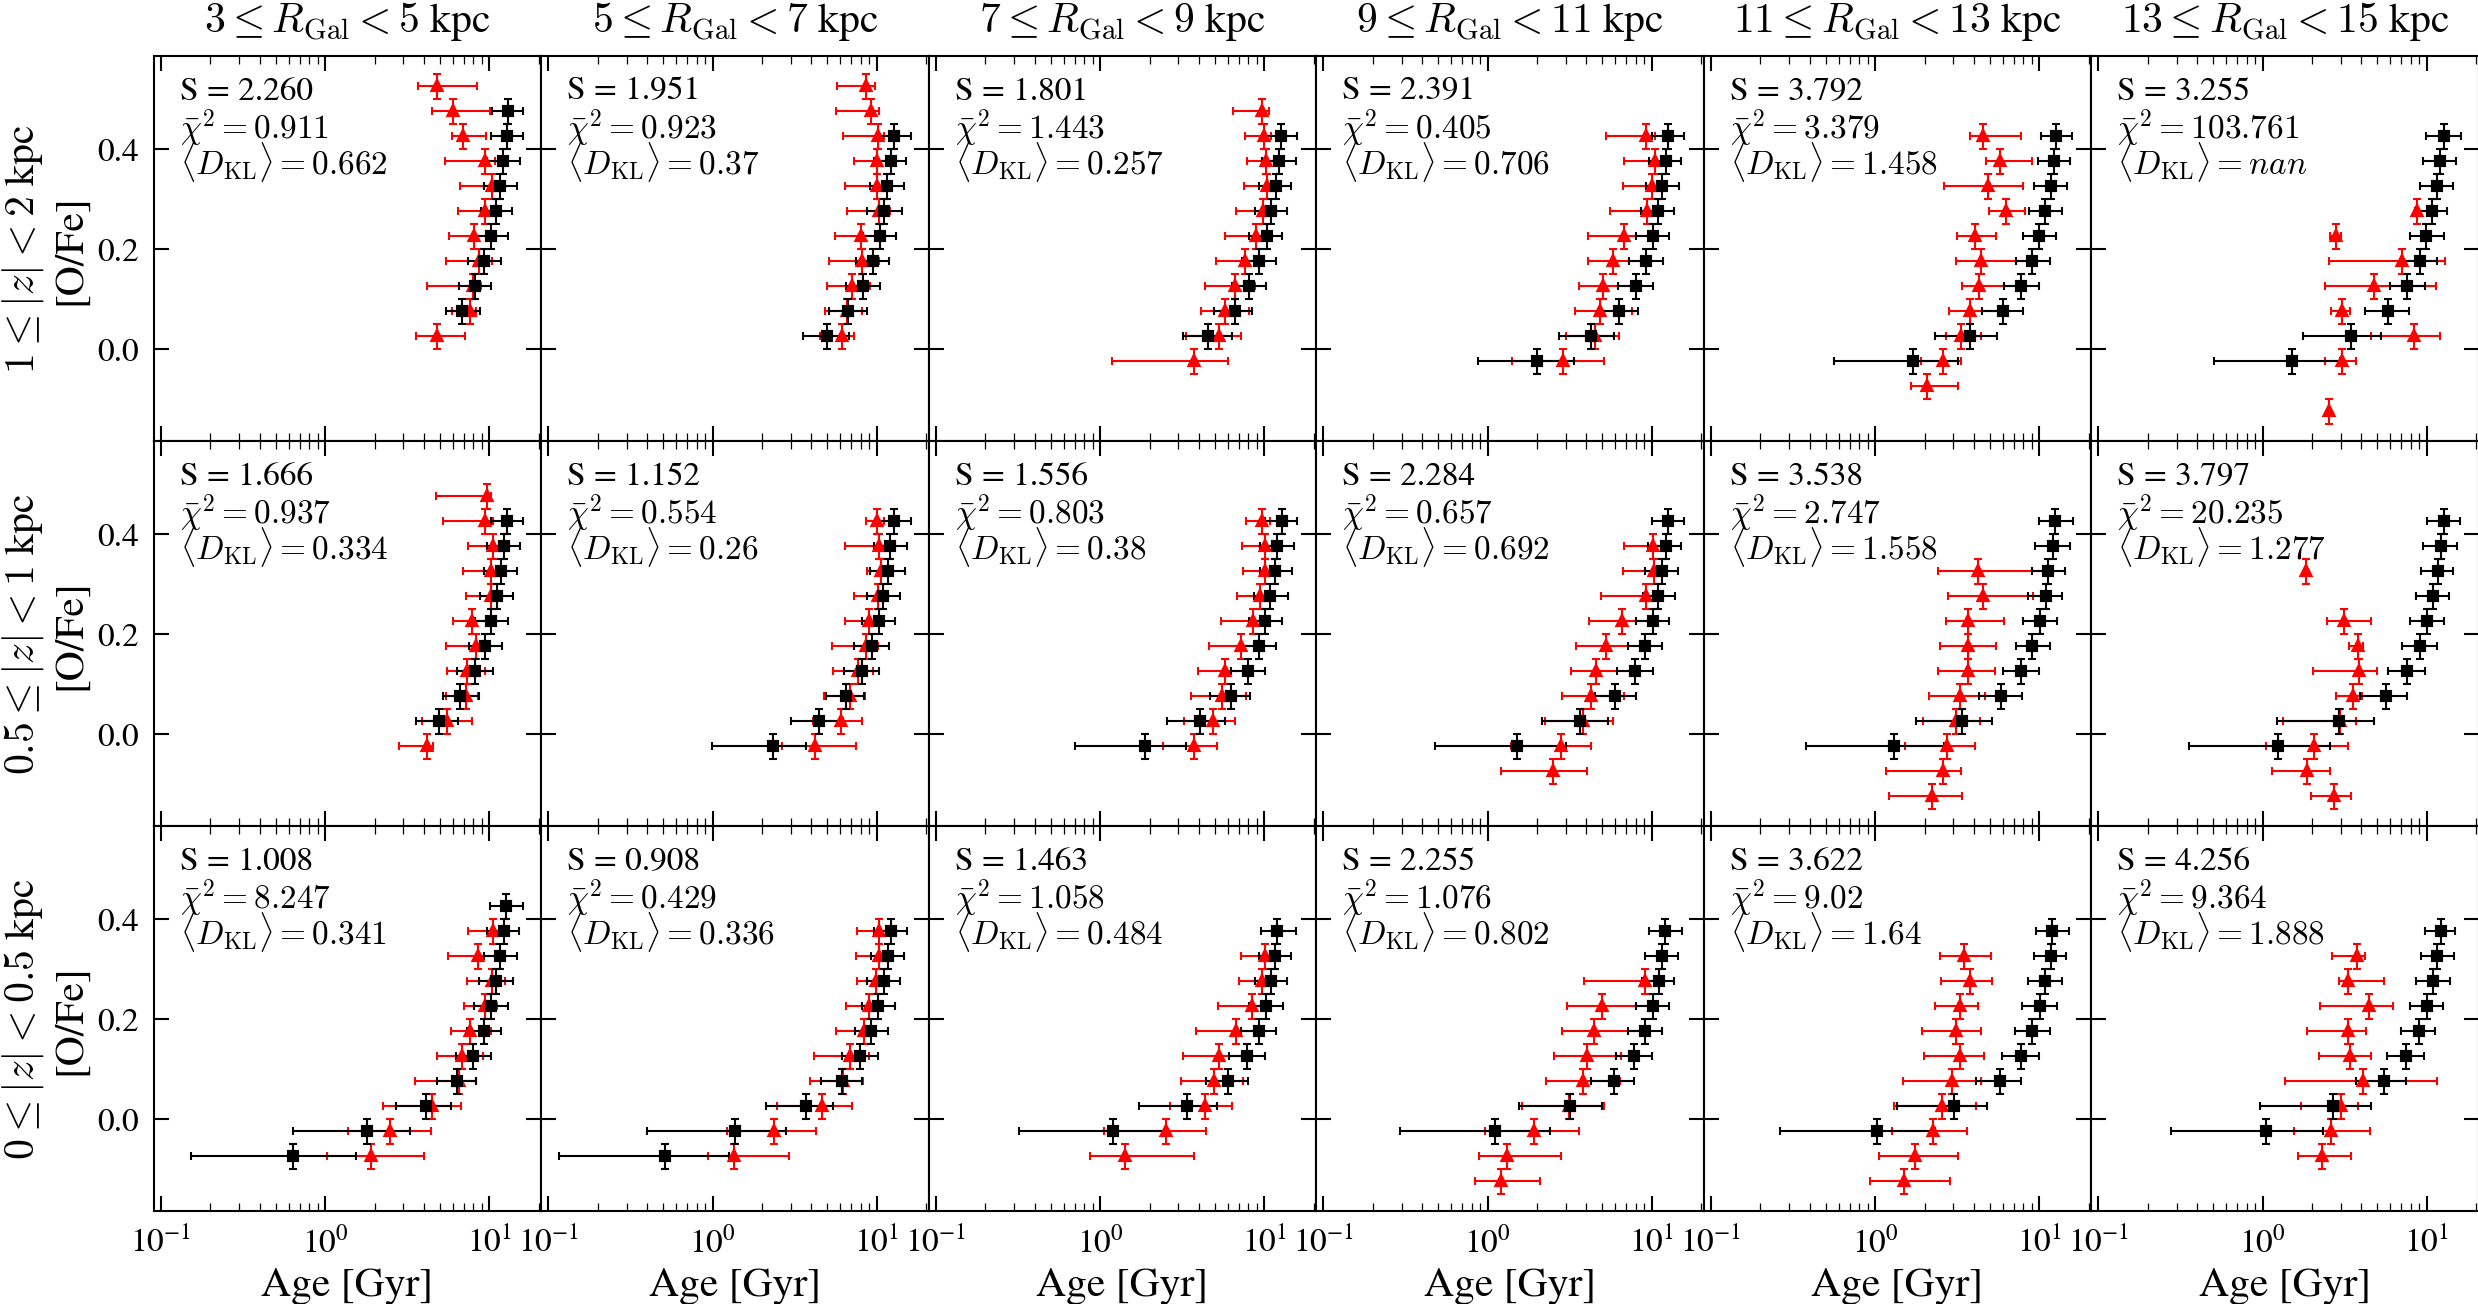

In [50]:
fig, axs = plt.subplots(len(_globals.ABSZ_BINS)-1, len(_globals.GALR_BINS)-1,
                        figsize=(10, 5), sharex=True, sharey=True)
plt.style.use(paths.styles / 'paper.mplstyle')
fig.subplots_adjust(wspace=0., hspace=0.)
xrange = (-0.15, 0.6)
stats = []
weights = []
pvals = []
for i, row in enumerate(axs):
    absz_lim = (_globals.ABSZ_BINS[-(i+2)], _globals.ABSZ_BINS[-(i+1)])
    for j, ax in enumerate(row):
        galr_lim = (_globals.GALR_BINS[j], _globals.GALR_BINS[j+1])
        # APOGEE DF
        apogee_subset = apogee_region(apogee_data, galr_lim, absz_lim)
        apogee_medians = plot_astroNN_medians(axs[i,j], apogee_subset, age_col='LATENT_AGE', 
                             label='L23', plot_low_count_bins=False)
        # VICE DF
        vice_subset = mzs1.model_uncertainty(apogee_data).region(galr_lim, absz_lim)
        vice_medians = plot_vice_medians(axs[i,j], vice_subset.stars, label='Model',
                          plot_low_mass_bins=False)
        # Old scores
        old_score = score_age_ofe(vice_subset, apogee_subset)
        ax.text(0.13, 0.5, f'S = {old_score:.3f}')
        # Chi-square
        df = pd.DataFrame({'APOGEE': apogee_medians[0], 
                           'VICE': vice_medians[0],
                           'stdev': np.sqrt((apogee_medians[2] - apogee_medians[0])**2 + (apogee_medians[0] - apogee_medians[1])**2)})
        df.dropna(how='any', inplace=True)
        df = df[df['stdev'] > 0]
        rx2 = redchisq(df['APOGEE'], df['VICE'], df['stdev'])
        ax.text(0.13, 0.42, r'$\bar\chi^2=%s$' % round(rx2, 3))
        # Weighted average binned KL divergence
        kld_avg = age_ofe_kld(vice_subset.stars, apogee_subset)
        ax.text(0.13, 0.35, r'$\langle D_{\rm KL}\rangle=%s$' % round(kld_avg, 3))
axs[0,0].set_xscale('log')
for i, ax in enumerate(axs[0,:]):
    ax.set_title(r'$%s\leq R_{\rm{Gal}} < %s$ kpc' % (_globals.GALR_BINS[i], _globals.GALR_BINS[i+1]))
for ax in axs[-1,:]:
    ax.set_xlabel('Age [Gyr]')
for i, ax in enumerate(axs[:,0]):
    absz_lim = (_globals.ABSZ_BINS[-(i+2)], _globals.ABSZ_BINS[-(i+1)])
    ax.set_ylabel(str(r'$%s\leq |z| < %s$ kpc' % absz_lim) + '\n[O/Fe]')
plt.show()